## TESTING TRACERS CODE:

1. Select a halo snapshot.
2. Compute Weigths with : st.weight_triaxial.
3. Compute Stellar properties. For densities purporses we need the masss.
4. Compute the density. Here we use the rho_enclosed function.

## To do:
## Check the values of the weights. 
## Check why the interpolation doesnt work for binsizes larger than 2.


In [8]:
%pylab inline
import Stracers as st
import sys
sys.path.append('../MW_anisotropy/code/')
sys.path.append('../MW_anisotropy/code/densities/')

#import density_tools
import reading_snapshots
from pygadgetreader import *



Populating the interactive namespace from numpy and matplotlib


In [9]:
font = {'size':20, 'family':'serif'}
matplotlib.rc('font', **font)

In [10]:
def rho_enclosed(r_posh, rmin, rmax, nbins, mass):
    r = np.linspace(rmin, rmax, nbins-1)
    rho = np.zeros(nbins-1)

    # Loop over the radial bins.
    for i in range(1, len(r)):
        indexh = np.where((r_posh<r[i]) & (r_posh>r[i-1]))[0]

        rho[i-1] = (3*(np.sum(mass[indexh]))) / (4*np.pi*(r[i]**3-r[i-1]**3))

    return r, rho

In [11]:
def all_host_particles(xyz, vxyz, pids, pot, mass, N_host_particles):
    """
    Function that return the host and the sat particles
    positions and velocities.

    Parameters:
    -----------
    xyz: snapshot coordinates with shape (n,3)
    vxys: snapshot velocities with shape (n,3)
    pids: particles ids
    Nhost_particles: Number of host particles in the snapshot
    Returns:
    --------
    xyz_mw, vxyz_mw, xyzlmc, vxyz_lmc: coordinates and velocities of
    the host and the sat.

    """
    sort_indexes = np.sort(pids)
    N_cut = sort_indexes[N_host_particles]
    host_ids = np.where(pids<N_cut)[0]
    return xyz[host_ids], vxyz[host_ids], pids[host_ids], pot[host_ids], mass[host_ids]

In [23]:
def Stellar_properties(ids_weights, weights, ids, mass, pos, vel):
    """
    Stellar properties:
    
    Function that assigns a stellar properties to DM particles using the weights from each DM particle.
    
    
    """
    
    assert len(ids_weights)<= len(ids), 'Error: length of weights ids is larger than lenght of the snapshot ids!'
    
    # Find indexes where ids are in ids_weights.
    common_ids = np.isin(ids, ids_weights)
    # selecting elements that are common in weight_ids and ids:
    
    ids_n = ids[common_ids]
    mass_n = mass[common_ids]
    pos_n = pos[common_ids]
    vel_n = vel[common_ids]
    
    print('Ids without weigths:', len(ids)-len(ids_n))
    
    assert len(ids_n) == len(ids_weights), 'Same number of particles'
    
    # Sorting to organize them:
    ids_w_arg_sort = np.argsort(ids_weights)
    ids_arg_sort = np.argsort(ids_n)
    
    # dumb checks!
    print(len(ids_n), len(ids_weights))
    print(len(ids_w_arg_sort), len(ids_arg_sort))
    
    
    #comp_items = ids_weights[ids_w_arg_sort]==ids_n[ids_arg_sort]
    #false_ind = np.where(comp_items==False)[0]
    
    #print(len(false_ind))
    
    #assert (len(false_ind)==0), 'Error: Hey!'
    
    # Sorting ids and properties
    weights_n = weights[ids_w_arg_sort]
    ids_weights_n = ids_weights[ids_w_arg_sort]
    
    # Sorting future properties and apply weights:
    
    ids_n = ids_n[ids_arg_sort]
    mass_n = mass_n[ids_arg_sort]*weights_n
    
    posx = pos_n[ids_arg_sort,0]
    posy = pos_n[ids_arg_sort,1]
    posz = pos_n[ids_arg_sort,2]

    velx = vel_n[ids_arg_sort,0]*weights_n
    vely = vel_n[ids_arg_sort,1]*weights_n
    velz = vel_n[ids_arg_sort,2]*weights_n
    
    all_pos = np.array([posx, posy, posz]).T
    all_vel = np.array([velx, vely, velz]).T
            
    return [ids_weights_n, weights_n, ids_n], mass_n, all_pos, all_vel

In [13]:
def energies(snap, rcut=0, LMC=0):

    MW_pos = readsnap(snap, 'pos', 'dm')
    MW_vel = readsnap(snap, 'vel', 'dm')
    MW_mass = readsnap(snap, 'mass', 'dm')
    MW_pot = readsnap(snap, 'pot', 'dm')
    MW_ids = readsnap(snap, 'pid', 'dm')

    
    # Selecting MW particles
    if LMC==1:
        N_host_particles = 100000000
        MW_pos, MW_vel, MW_ids, MW_pot, MW_mass = all_host_particles(pp, vv, ids, Epp, massarr, N_host_particles)
        assert len(MW_ids)==N_host_particles, 'Error: something went wrong selecting the host particles'
    
    
    rr=np.sqrt(MW_pos[:,0]**2+MW_pos[:,1]**2+MW_pos[:,2]**2)
    
    
    if rcut>0:
        r_cut = np.where((rr<rcut))[0]

        rr = rr[r_cut]
        MW_pos = MW_pos[r_cut]
        MW_vel = MW_vel[r_cut]
        MW_mass = MW_mass[r_cut]
        MW_pot = MW_pot[r_cut]
        MW_ids = MW_ids[r_cut]

    v2=MW_vel[:,0]**2+MW_vel[:,1]**2+MW_vel[:,2]**2
    Ekk=0.5*v2
    
    return rr, Ekk, MW_pot, MW_ids, MW_mass, MW_pos, MW_vel


In [15]:
rr_init, Ekk_init, Epp_init, ids_init, massarr_init, mw_pos, mw_vel = energies('./halos/LMC3_2M_vir_000'
                                                                               , rcut=300)

Returning DM    Positions
Returning DM    Velocities
Returning DM    Mass
Returning DM    Potential
Returning DM    Particle IDs


In [16]:
rr_fut, Ekk_fut, Epp_fut, ids_fut, massarr_fut, mw_pos_f, mw_vel_f = energies('./halos/LMC3_2M_vir_009')

Returning DM    Positions
Returning DM    Velocities
Returning DM    Mass
Returning DM    Potential
Returning DM    Particle IDs


With binsize 0.05
With binsize 0.1
With binsize 2


error: (m>k) failed for hidden m: fpcurf0:m=1

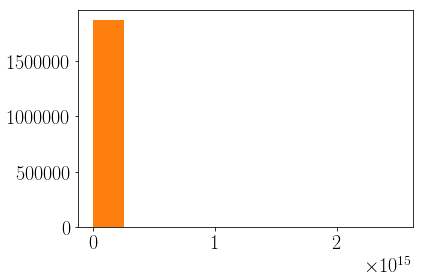

In [25]:
#Computing weights
binsize = [0.05, 0.1, 2]
n_bins = 200
for i in range(len(binsize)):
    print('With binsize {}'.format(binsize[i]))
    wh, w_ids_h = st.weight_triaxial(rr_init, Ekk_init, Epp_init, ids_init, massarr_init[3],
                                     binsize[i], n_bins, 1, 'Hernquist', [25])
    
    hist(wh)
    """
    ST_init = Stellar_properties(w_ids_h, wh, ids_init, massarr_init, mw_pos, mw_vel)
    ST_fut = Stellar_properties(w_ids_h, wh, ids_fut, massarr_fut, mw_pos_f, mw_vel_f)
    all_i, mass_n_i, pos_i, vel_i = ST_init
    all_f, mass_n_f, pos_f, vel_f = ST_fut
    ri_dm, rho_dm_init = rho_enclosed(rr_init, 1, 300, 100, massarr_init*1E10)
    rf_dm, rho_dm_f = rho_enclosed(rr_fut, 1, 300, 100, massarr_fut*1E10)
    
    r_pos_i_s = np.sqrt(pos_i[:,0]**2 + pos_i[:,1]**2 + pos_i[:,2]**2)
    r_pos_f_s = np.sqrt(pos_f[:,0]**2 + pos_f[:,1]**2 + pos_f[:,2]**2)
    
    ri_st, rho_st_init = rho_enclosed(r_pos_i_s, 1, 300, 100, mass_n_i)
    rf_st, rho_st_f = rho_enclosed(r_pos_f_s, 1, 300, 100, mass_n_f)
    
    figure(figsize=(6, 4.5))
    title('Bin size = {}'.format(binsize[i]))
    loglog(ri_dm, rho_dm_init, c='k', label = '$t=0 Gyr$')
    loglog(rf_dm, rho_dm_f, label= '$t=3 Gyr$')

    loglog(ri_st, rho_st_init, c='k', label = '$t=0 Gyr$', ls='--')
    loglog(rf_st, rho_st_f, label= '$t=3 Gyr$', ls='--')

    legend(fontsize=15)

    ylabel(r'$\rho$')
    xlabel('$r[Kpc]$')
    """

95199 95199
95199 95199
95199 95199
0
97000 95199
95199 95199
95199 95199
0
95199 95199
95199 95199
95199 95199
0


/home/xzk/work/github/tracers_triaxial/Stracers/weights.py:181: RuntimeWarning: overflow encountered in true_divide
  Weights=distribution_function[indsort[::-1]]/((Histo_M)/density_of_states)
/home/xzk/work/github/tracers_triaxial/Stracers/weights.py:181: RuntimeWarning: divide by zero encountered in true_divide
  Weights=distribution_function[indsort[::-1]]/((Histo_M)/density_of_states)


97000 95199
95199 95199
95199 95199
0
95199 95199
95199 95199
95199 95199
0
97000 95199
95199 95199
95199 95199
0
95199 95199
95199 95199
95199 95199
0
97000 95199
95199 95199
95199 95199
0


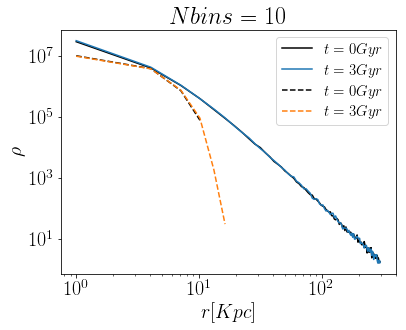

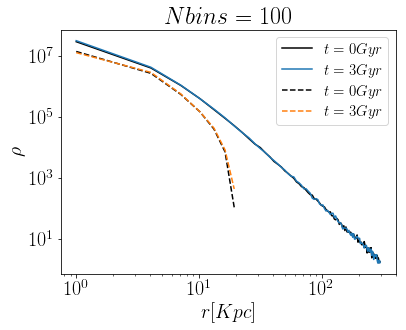

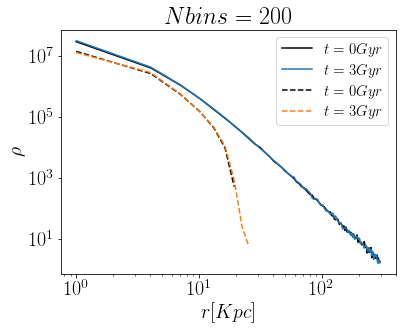

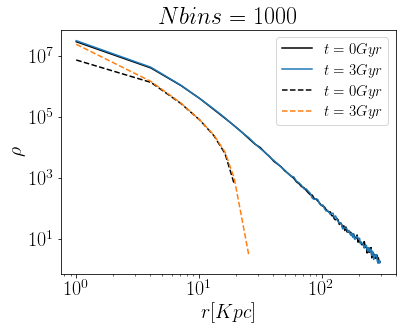

In [108]:
#Computing weights
binsize = [1]
n_bins = [10, 100, 200, 1000]
for i in range(len(n_bins)):
    wh, w_ids_h = st.weight_triaxial(rr_init, Ekk_init, Epp_init, ids_init, massarr_init[3],
                                     binsize[0], n_bins[i], 1, 'Hernquist', [25])
    ST_init  = Stellar_properties(w_ids_h, wh, ids_init, massarr_init, mw_pos, mw_vel)
    ST_fut  = Stellar_properties(w_ids_h, wh, ids_fut, massarr_fut, mw_pos_f, mw_vel_f)
    all_i, mass_n_i, pos_i, vel_i = ST_init
    all_f, mass_n_f, pos_f, vel_f = ST_fut
    ri_dm, rho_dm_init = rho_enclosed(rr_init, 1, 300, 100, massarr_init*1E10)
    rf_dm, rho_dm_f = rho_enclosed(rr_fut, 1, 300, 100, massarr_fut*1E10)
    
    r_pos_i_s = np.sqrt(pos_i[:,0]**2 + pos_i[:,1]**2 + pos_i[:,2]**2)
    r_pos_f_s = np.sqrt(pos_f[:,0]**2 + pos_f[:,1]**2 + pos_f[:,2]**2)
    
    ri_st, rho_st_init = rho_enclosed(r_pos_i_s, 1, 300, 100, mass_n_i)
    rf_st, rho_st_f = rho_enclosed(r_pos_f_s, 1, 300, 100, mass_n_f)
    
    figure(figsize=(6, 4.5))
    title('$Nbins = {:.0f}$'.format(n_bins[i]))
    loglog(ri_dm, rho_dm_init, c='k', label = '$t=0 Gyr$')
    loglog(rf_dm, rho_dm_f, label= '$t=3 Gyr$')

    loglog(ri_st, rho_st_init, c='k', label = '$t=0 Gyr$', ls='--')
    loglog(rf_st, rho_st_f, label= '$t=3 Gyr$', ls='--')

    legend(fontsize=15)

    ylabel(r'$\rho$')
    xlabel('$r[Kpc]$')

Text(0.5,0,'$r[Kpc]$')

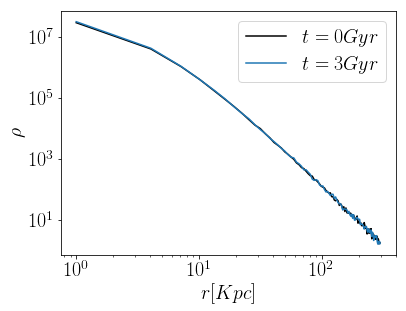

In [76]:
figure(figsize=(6, 4.5))
loglog(ri_dm, rho_dm_init, c='k', label = '$t=0 Gyr$')
loglog(rf_dm, rho_dm_f, label= '$t=3 Gyr$')
legend()

ylabel(r'$\rho$')
xlabel('$r[Kpc]$')

Text(0.5,0,'$r[Kpc]$')

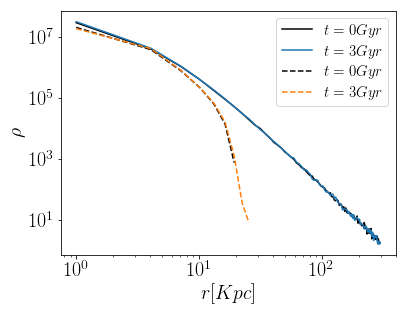

In [79]:
figure(figsize=(6, 4.5))
loglog(ri_dm, rho_dm_init, c='k', label = '$t=0 Gyr$')
loglog(rf_dm, rho_dm_f, label= '$t=3 Gyr$')

loglog(ri_st, rho_st_init, c='k', label = '$t=0 Gyr$', ls='--')
loglog(rf_st, rho_st_f, label= '$t=3 Gyr$', ls='--')

legend(fontsize=15)

ylabel(r'$\rho$')
xlabel('$r[Kpc]$')

In [67]:
# computing 2d densities
rho_mw_st_init = density_tools.density_nn(pos_i, 100, 100, 10, 1000, mass=mass_n_i)

In [68]:
# computing 2d densities
rho_mw_st_fut = density_tools.density_nn(pos_f, 100, 100, 10, 1000, mass=mass_n_f)

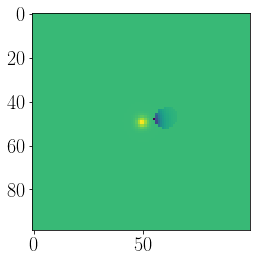

In [69]:
imshow(rho_mw_st_init)

In [ ]:
density_tools.density_peaks(np.log(rho_mw_dm)/np.max(np.log(rho_mw_dm)), xmin=-100, xmax=100, 
                            ymin=-100, ymax=100, fsize=(6, 4.5),  levels=np.arange(0, 1.05, 0.1))